<a href="https://colab.research.google.com/github/Precious3ita/Top-spotify-listening/blob/main/neuralNetwork2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Load
df = pd.read_csv("ENB2012_data.csv")
df.head()


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [5]:
print(df.shape)
print(df.isna().sum())   # missing values
print(df.describe())

# Correlation with target
print(df.corr()['Y1'].sort_values(ascending=False))


(768, 10)
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64
               X1          X2          X3          X4         X5          X6  \
count  768.000000  768.000000  768.000000  768.000000  768.00000  768.000000   
mean     0.764167  671.708333  318.500000  176.604167    5.25000    3.500000   
std      0.105777   88.086116   43.626481   45.165950    1.75114    1.118763   
min      0.620000  514.500000  245.000000  110.250000    3.50000    2.000000   
25%      0.682500  606.375000  294.000000  140.875000    3.50000    2.750000   
50%      0.750000  673.750000  318.500000  183.750000    5.25000    3.500000   
75%      0.830000  741.125000  343.000000  220.500000    7.00000    4.250000   
max      0.980000  808.500000  416.500000  220.500000    7.00000    5.000000   

               X7         X8          Y1          Y2  
count  768.000000  768.00000  768.000000  768.000000  
mean     0.234375    2.81250   22.307201   24.587760  
std      0.

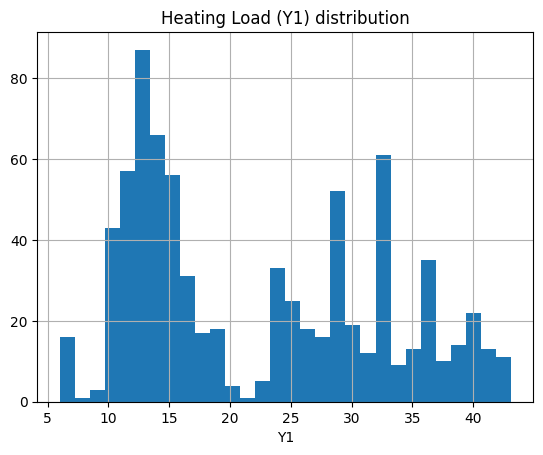

In [6]:
df['Y1'].hist(bins=30)
plt.title("Heating Load (Y1) distribution")
plt.xlabel("Y1")
plt.show()


In [7]:
X = df.drop(columns=['Y1', 'Y2'])  # inputs
y = df['Y1']


Train / validation / test split

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.17647, random_state=42)
# 0.17647 * 0.85 ≈ 0.15, so overall ~70/15/15

print(X_train.shape, X_val.shape, X_test.shape)


(536, 8) (116, 8) (116, 8)


Feature scaling

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


Build a baseline neural network

In [11]:
input_dim = X_train_scaled.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)   # regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Add callbacks for safer training

In [12]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
mc = callbacks.ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)


Train the model

In [13]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=16,
    callbacks=[es, mc],
    verbose=2
)


Epoch 1/200


34/34 - 1s - 43ms/step - loss: 552.3397 - mae: 21.2017 - val_loss: 411.8936 - val_mae: 17.9027
Epoch 2/200


34/34 - 0s - 5ms/step - loss: 421.0878 - mae: 17.8285 - val_loss: 246.5908 - val_mae: 13.0251
Epoch 3/200


34/34 - 0s - 5ms/step - loss: 207.1807 - mae: 11.3435 - val_loss: 59.4092 - val_mae: 5.3408
Epoch 4/200


34/34 - 0s - 5ms/step - loss: 59.0418 - mae: 5.3804 - val_loss: 19.5524 - val_mae: 2.8920
Epoch 5/200


34/34 - 0s - 5ms/step - loss: 34.9391 - mae: 3.9711 - val_loss: 15.6640 - val_mae: 2.7168
Epoch 6/200


34/34 - 0s - 5ms/step - loss: 28.9125 - mae: 3.7604 - val_loss: 14.2575 - val_mae: 2.7560
Epoch 7/200


34/34 - 0s - 5ms/step - loss: 25.7723 - mae: 3.6557 - val_loss: 13.5642 - val_mae: 2.7333
Epoch 8/200


34/34 - 0s - 5ms/step - loss: 23.5641 - mae: 3.5028 - val_loss: 12.4796 - val_mae: 2.6102
Epoch 9/200


34/34 - 0s - 5ms/step - loss: 21.7293 - mae: 3.3617 - val_loss: 11.8981 - val_mae: 2.5820
Epoch 10/200


34/34 - 0s - 5ms/step - loss: 20.1029 - mae: 3.2734 - val_loss: 11.8667 - val_mae: 2.5946
Epoch 11/200


34/34 - 0s - 5ms/step - loss: 18.6093 - mae: 3.1478 - val_loss: 10.8952 - val_mae: 2.4903
Epoch 12/200


34/34 - 0s - 5ms/step - loss: 17.3321 - mae: 3.0424 - val_loss: 10.1353 - val_mae: 2.3998
Epoch 13/200


34/34 - 0s - 5ms/step - loss: 16.2397 - mae: 2.9742 - val_loss: 9.6200 - val_mae: 2.3482
Epoch 14/200


34/34 - 0s - 6ms/step - loss: 15.2491 - mae: 2.8595 - val_loss: 9.2845 - val_mae: 2.3181
Epoch 15/200
34/34 - 0s - 4ms/step - loss: 14.4851 - mae: 2.8097 - val_loss: 9.3102 - val_mae: 2.3545
Epoch 16/200


34/34 - 0s - 5ms/step - loss: 13.6937 - mae: 2.7541 - val_loss: 8.2629 - val_mae: 2.2013
Epoch 17/200


34/34 - 0s - 5ms/step - loss: 13.0215 - mae: 2.6456 - val_loss: 8.0828 - val_mae: 2.1997
Epoch 18/200


34/34 - 0s - 5ms/step - loss: 12.4679 - mae: 2.6108 - val_loss: 7.8825 - val_mae: 2.1690
Epoch 19/200


34/34 - 0s - 5ms/step - loss: 11.9089 - mae: 2.5666 - val_loss: 6.9761 - val_mae: 2.0278
Epoch 20/200


34/34 - 0s - 6ms/step - loss: 11.3573 - mae: 2.5105 - val_loss: 6.7316 - val_mae: 1.9869
Epoch 21/200


34/34 - 0s - 5ms/step - loss: 11.0324 - mae: 2.4572 - val_loss: 6.5870 - val_mae: 1.9733
Epoch 22/200


34/34 - 0s - 5ms/step - loss: 10.6668 - mae: 2.3982 - val_loss: 6.3717 - val_mae: 1.9397
Epoch 23/200


34/34 - 0s - 5ms/step - loss: 10.3710 - mae: 2.3641 - val_loss: 6.1310 - val_mae: 1.9068
Epoch 24/200


34/34 - 0s - 5ms/step - loss: 10.1572 - mae: 2.3566 - val_loss: 5.9623 - val_mae: 1.8503
Epoch 25/200
34/34 - 0s - 4ms/step - loss: 9.8943 - mae: 2.2942 - val_loss: 6.1868 - val_mae: 1.9173
Epoch 26/200


34/34 - 0s - 6ms/step - loss: 9.7205 - mae: 2.2811 - val_loss: 5.6818 - val_mae: 1.8206
Epoch 27/200


34/34 - 0s - 5ms/step - loss: 9.5637 - mae: 2.2561 - val_loss: 5.4944 - val_mae: 1.7921
Epoch 28/200
34/34 - 0s - 4ms/step - loss: 9.4114 - mae: 2.2193 - val_loss: 5.6839 - val_mae: 1.8331
Epoch 29/200


34/34 - 0s - 8ms/step - loss: 9.2517 - mae: 2.2169 - val_loss: 5.2859 - val_mae: 1.7394
Epoch 30/200


34/34 - 0s - 9ms/step - loss: 9.3471 - mae: 2.2102 - val_loss: 5.1609 - val_mae: 1.7107
Epoch 31/200


34/34 - 0s - 9ms/step - loss: 9.1703 - mae: 2.1882 - val_loss: 5.0779 - val_mae: 1.7084
Epoch 32/200
34/34 - 0s - 6ms/step - loss: 9.0626 - mae: 2.1635 - val_loss: 5.1263 - val_mae: 1.7161
Epoch 33/200


34/34 - 0s - 9ms/step - loss: 8.7562 - mae: 2.1520 - val_loss: 5.0070 - val_mae: 1.6824
Epoch 34/200


34/34 - 0s - 8ms/step - loss: 8.6670 - mae: 2.1078 - val_loss: 4.8826 - val_mae: 1.6691
Epoch 35/200


34/34 - 0s - 9ms/step - loss: 8.5646 - mae: 2.1008 - val_loss: 4.7907 - val_mae: 1.6240
Epoch 36/200


34/34 - 0s - 9ms/step - loss: 8.4170 - mae: 2.0677 - val_loss: 4.6693 - val_mae: 1.6271
Epoch 37/200


34/34 - 0s - 6ms/step - loss: 8.3161 - mae: 2.0758 - val_loss: 4.6571 - val_mae: 1.6342
Epoch 38/200
34/34 - 0s - 5ms/step - loss: 8.3014 - mae: 2.0495 - val_loss: 4.6743 - val_mae: 1.6070
Epoch 39/200


34/34 - 0s - 5ms/step - loss: 8.1190 - mae: 2.0359 - val_loss: 4.5255 - val_mae: 1.6063
Epoch 40/200
34/34 - 0s - 4ms/step - loss: 8.0870 - mae: 2.0300 - val_loss: 4.6536 - val_mae: 1.6191
Epoch 41/200


34/34 - 0s - 5ms/step - loss: 7.9573 - mae: 2.0043 - val_loss: 4.3829 - val_mae: 1.5572
Epoch 42/200
34/34 - 0s - 8ms/step - loss: 7.9338 - mae: 2.0193 - val_loss: 4.6289 - val_mae: 1.6075
Epoch 43/200
34/34 - 0s - 4ms/step - loss: 7.7819 - mae: 1.9793 - val_loss: 4.6936 - val_mae: 1.6056
Epoch 44/200


34/34 - 0s - 5ms/step - loss: 7.8961 - mae: 2.0069 - val_loss: 4.3428 - val_mae: 1.5627
Epoch 45/200


34/34 - 0s - 5ms/step - loss: 7.5320 - mae: 1.9383 - val_loss: 4.3130 - val_mae: 1.5471
Epoch 46/200


34/34 - 0s - 8ms/step - loss: 7.5133 - mae: 1.9337 - val_loss: 4.2259 - val_mae: 1.5250
Epoch 47/200


34/34 - 0s - 5ms/step - loss: 7.4009 - mae: 1.9158 - val_loss: 4.1240 - val_mae: 1.5124
Epoch 48/200
34/34 - 0s - 4ms/step - loss: 7.3958 - mae: 1.9080 - val_loss: 4.2753 - val_mae: 1.5304
Epoch 49/200
34/34 - 0s - 4ms/step - loss: 7.4115 - mae: 1.9113 - val_loss: 4.4591 - val_mae: 1.5540
Epoch 50/200


34/34 - 0s - 6ms/step - loss: 7.2340 - mae: 1.8868 - val_loss: 3.9870 - val_mae: 1.4910
Epoch 51/200


34/34 - 0s - 8ms/step - loss: 7.0574 - mae: 1.8718 - val_loss: 3.8305 - val_mae: 1.4524
Epoch 52/200


34/34 - 0s - 5ms/step - loss: 6.9069 - mae: 1.8319 - val_loss: 3.8198 - val_mae: 1.4634
Epoch 53/200


34/34 - 0s - 5ms/step - loss: 6.7249 - mae: 1.8069 - val_loss: 3.6545 - val_mae: 1.4390
Epoch 54/200


34/34 - 0s - 5ms/step - loss: 6.8460 - mae: 1.8220 - val_loss: 3.5369 - val_mae: 1.4089
Epoch 55/200
34/34 - 0s - 5ms/step - loss: 6.7860 - mae: 1.8589 - val_loss: 3.6355 - val_mae: 1.4448
Epoch 56/200


34/34 - 0s - 9ms/step - loss: 6.4809 - mae: 1.7711 - val_loss: 3.4172 - val_mae: 1.3729
Epoch 57/200
34/34 - 0s - 4ms/step - loss: 6.4325 - mae: 1.7815 - val_loss: 3.5631 - val_mae: 1.4081
Epoch 58/200


34/34 - 0s - 5ms/step - loss: 6.2687 - mae: 1.7564 - val_loss: 3.3108 - val_mae: 1.3443
Epoch 59/200


34/34 - 0s - 5ms/step - loss: 6.0978 - mae: 1.7053 - val_loss: 3.1931 - val_mae: 1.3492
Epoch 60/200


34/34 - 0s - 6ms/step - loss: 5.9856 - mae: 1.7105 - val_loss: 3.1012 - val_mae: 1.3370
Epoch 61/200


34/34 - 0s - 6ms/step - loss: 5.7924 - mae: 1.6692 - val_loss: 3.0076 - val_mae: 1.2829
Epoch 62/200
34/34 - 0s - 4ms/step - loss: 5.8097 - mae: 1.6644 - val_loss: 3.0860 - val_mae: 1.2661
Epoch 63/200


34/34 - 0s - 5ms/step - loss: 5.7275 - mae: 1.6447 - val_loss: 2.7909 - val_mae: 1.2270
Epoch 64/200
34/34 - 0s - 9ms/step - loss: 5.5122 - mae: 1.6451 - val_loss: 3.8048 - val_mae: 1.3741
Epoch 65/200


34/34 - 0s - 5ms/step - loss: 5.5741 - mae: 1.6142 - val_loss: 2.6537 - val_mae: 1.2006
Epoch 66/200


34/34 - 0s - 6ms/step - loss: 5.3247 - mae: 1.5664 - val_loss: 2.5990 - val_mae: 1.1491
Epoch 67/200


34/34 - 0s - 5ms/step - loss: 5.2387 - mae: 1.5519 - val_loss: 2.4835 - val_mae: 1.1122
Epoch 68/200


34/34 - 0s - 5ms/step - loss: 5.1652 - mae: 1.5161 - val_loss: 2.4298 - val_mae: 1.1352
Epoch 69/200


34/34 - 0s - 5ms/step - loss: 5.0095 - mae: 1.5076 - val_loss: 2.4136 - val_mae: 1.1094
Epoch 70/200
34/34 - 0s - 4ms/step - loss: 4.9189 - mae: 1.4850 - val_loss: 2.4506 - val_mae: 1.1455
Epoch 71/200


34/34 - 0s - 5ms/step - loss: 4.7877 - mae: 1.5139 - val_loss: 2.4109 - val_mae: 1.0916
Epoch 72/200


34/34 - 0s - 5ms/step - loss: 4.6914 - mae: 1.4414 - val_loss: 2.2346 - val_mae: 1.0535
Epoch 73/200
34/34 - 0s - 4ms/step - loss: 4.6208 - mae: 1.4762 - val_loss: 2.3062 - val_mae: 1.0774
Epoch 74/200


34/34 - 0s - 5ms/step - loss: 4.5219 - mae: 1.4456 - val_loss: 2.2224 - val_mae: 1.0481
Epoch 75/200


34/34 - 0s - 5ms/step - loss: 4.4217 - mae: 1.4271 - val_loss: 2.1408 - val_mae: 1.0127
Epoch 76/200


34/34 - 0s - 5ms/step - loss: 4.3475 - mae: 1.4090 - val_loss: 2.0949 - val_mae: 1.0328
Epoch 77/200
34/34 - 0s - 4ms/step - loss: 4.2368 - mae: 1.3986 - val_loss: 2.1054 - val_mae: 1.0150
Epoch 78/200


34/34 - 0s - 5ms/step - loss: 4.1501 - mae: 1.4063 - val_loss: 1.9358 - val_mae: 0.9685
Epoch 79/200
34/34 - 0s - 4ms/step - loss: 4.1328 - mae: 1.3749 - val_loss: 1.9674 - val_mae: 0.9841
Epoch 80/200
34/34 - 0s - 4ms/step - loss: 3.9325 - mae: 1.3568 - val_loss: 2.2157 - val_mae: 1.0049
Epoch 81/200


34/34 - 0s - 5ms/step - loss: 3.8868 - mae: 1.3392 - val_loss: 1.8635 - val_mae: 0.9527
Epoch 82/200


34/34 - 0s - 5ms/step - loss: 3.7748 - mae: 1.3243 - val_loss: 1.8602 - val_mae: 0.9571
Epoch 83/200
34/34 - 0s - 4ms/step - loss: 3.6095 - mae: 1.2956 - val_loss: 1.8630 - val_mae: 0.9779
Epoch 84/200


34/34 - 0s - 6ms/step - loss: 3.6293 - mae: 1.2827 - val_loss: 1.7899 - val_mae: 0.9319
Epoch 85/200
34/34 - 0s - 4ms/step - loss: 3.5119 - mae: 1.2868 - val_loss: 2.0187 - val_mae: 1.0336
Epoch 86/200


34/34 - 0s - 5ms/step - loss: 3.3891 - mae: 1.2681 - val_loss: 1.7409 - val_mae: 0.9267
Epoch 87/200


34/34 - 0s - 5ms/step - loss: 3.2401 - mae: 1.2108 - val_loss: 1.7260 - val_mae: 0.9440
Epoch 88/200


34/34 - 0s - 5ms/step - loss: 3.1603 - mae: 1.2432 - val_loss: 1.6537 - val_mae: 0.9152
Epoch 89/200


34/34 - 0s - 5ms/step - loss: 3.0722 - mae: 1.1864 - val_loss: 1.6170 - val_mae: 0.9044
Epoch 90/200


34/34 - 0s - 5ms/step - loss: 2.9363 - mae: 1.1752 - val_loss: 1.6100 - val_mae: 0.9111
Epoch 91/200


34/34 - 0s - 5ms/step - loss: 2.8798 - mae: 1.1879 - val_loss: 1.6007 - val_mae: 0.8985
Epoch 92/200


34/34 - 0s - 9ms/step - loss: 2.8036 - mae: 1.1417 - val_loss: 1.5466 - val_mae: 0.8893
Epoch 93/200
34/34 - 0s - 6ms/step - loss: 2.7055 - mae: 1.1279 - val_loss: 1.5586 - val_mae: 0.9002
Epoch 94/200


34/34 - 0s - 8ms/step - loss: 2.7014 - mae: 1.1525 - val_loss: 1.5407 - val_mae: 0.8895
Epoch 95/200


34/34 - 0s - 8ms/step - loss: 2.7463 - mae: 1.1795 - val_loss: 1.4795 - val_mae: 0.8756
Epoch 96/200


34/34 - 0s - 8ms/step - loss: 2.6031 - mae: 1.1106 - val_loss: 1.4388 - val_mae: 0.8418
Epoch 97/200
34/34 - 0s - 8ms/step - loss: 2.5222 - mae: 1.1076 - val_loss: 1.4476 - val_mae: 0.8608
Epoch 98/200
34/34 - 0s - 8ms/step - loss: 2.3367 - mae: 1.0525 - val_loss: 1.6852 - val_mae: 0.9384
Epoch 99/200
34/34 - 0s - 8ms/step - loss: 2.4243 - mae: 1.0907 - val_loss: 1.4492 - val_mae: 0.8810
Epoch 100/200
34/34 - 0s - 8ms/step - loss: 2.2655 - mae: 1.0691 - val_loss: 1.8017 - val_mae: 0.9789
Epoch 101/200


34/34 - 0s - 5ms/step - loss: 2.2859 - mae: 1.0929 - val_loss: 1.3621 - val_mae: 0.8690
Epoch 102/200


34/34 - 0s - 5ms/step - loss: 2.1176 - mae: 1.0490 - val_loss: 1.3614 - val_mae: 0.8637
Epoch 103/200
34/34 - 0s - 5ms/step - loss: 2.0640 - mae: 1.0204 - val_loss: 1.4772 - val_mae: 0.8943
Epoch 104/200


34/34 - 0s - 5ms/step - loss: 2.0788 - mae: 1.0123 - val_loss: 1.2896 - val_mae: 0.8263
Epoch 105/200


34/34 - 0s - 5ms/step - loss: 1.9116 - mae: 0.9770 - val_loss: 1.2746 - val_mae: 0.8163
Epoch 106/200
34/34 - 0s - 5ms/step - loss: 1.9641 - mae: 0.9995 - val_loss: 1.3774 - val_mae: 0.8462
Epoch 107/200


34/34 - 0s - 5ms/step - loss: 1.8501 - mae: 0.9736 - val_loss: 1.1351 - val_mae: 0.7880
Epoch 108/200
34/34 - 0s - 4ms/step - loss: 1.7267 - mae: 0.9332 - val_loss: 1.3512 - val_mae: 0.8626
Epoch 109/200
34/34 - 0s - 5ms/step - loss: 1.7018 - mae: 0.9369 - val_loss: 1.3595 - val_mae: 0.8670
Epoch 110/200


34/34 - 0s - 9ms/step - loss: 1.6251 - mae: 0.9162 - val_loss: 1.0682 - val_mae: 0.7702
Epoch 111/200


34/34 - 0s - 5ms/step - loss: 1.6127 - mae: 0.9015 - val_loss: 1.0669 - val_mae: 0.7643
Epoch 112/200


34/34 - 0s - 5ms/step - loss: 1.5556 - mae: 0.8892 - val_loss: 1.0225 - val_mae: 0.7423
Epoch 113/200
34/34 - 0s - 4ms/step - loss: 1.4379 - mae: 0.8507 - val_loss: 1.2194 - val_mae: 0.8147
Epoch 114/200


34/34 - 0s - 5ms/step - loss: 1.4332 - mae: 0.8549 - val_loss: 0.9906 - val_mae: 0.7439
Epoch 115/200
34/34 - 0s - 5ms/step - loss: 1.3579 - mae: 0.8368 - val_loss: 1.0161 - val_mae: 0.7656
Epoch 116/200
34/34 - 0s - 5ms/step - loss: 1.3461 - mae: 0.8408 - val_loss: 1.0373 - val_mae: 0.7705
Epoch 117/200


34/34 - 0s - 5ms/step - loss: 1.2690 - mae: 0.8119 - val_loss: 0.9430 - val_mae: 0.7402
Epoch 118/200


34/34 - 0s - 5ms/step - loss: 1.2210 - mae: 0.8073 - val_loss: 0.9005 - val_mae: 0.7243
Epoch 119/200
34/34 - 0s - 4ms/step - loss: 1.1822 - mae: 0.7867 - val_loss: 1.0877 - val_mae: 0.8081
Epoch 120/200
34/34 - 0s - 4ms/step - loss: 1.1727 - mae: 0.7942 - val_loss: 0.9466 - val_mae: 0.7333
Epoch 121/200
34/34 - 0s - 5ms/step - loss: 1.0836 - mae: 0.7557 - val_loss: 1.0199 - val_mae: 0.7770
Epoch 122/200
34/34 - 0s - 4ms/step - loss: 1.0785 - mae: 0.7565 - val_loss: 0.9052 - val_mae: 0.7248
Epoch 123/200


34/34 - 0s - 5ms/step - loss: 1.0166 - mae: 0.7349 - val_loss: 0.8376 - val_mae: 0.7060
Epoch 124/200
34/34 - 0s - 8ms/step - loss: 0.9731 - mae: 0.7196 - val_loss: 0.9123 - val_mae: 0.7069
Epoch 125/200


34/34 - 0s - 5ms/step - loss: 0.9531 - mae: 0.7051 - val_loss: 0.7706 - val_mae: 0.6692
Epoch 126/200
34/34 - 0s - 5ms/step - loss: 0.8930 - mae: 0.6793 - val_loss: 0.8649 - val_mae: 0.7146
Epoch 127/200
34/34 - 0s - 9ms/step - loss: 0.9066 - mae: 0.6989 - val_loss: 0.8052 - val_mae: 0.6951
Epoch 128/200


34/34 - 0s - 5ms/step - loss: 0.8519 - mae: 0.6826 - val_loss: 0.7529 - val_mae: 0.6672
Epoch 129/200


34/34 - 0s - 5ms/step - loss: 0.8477 - mae: 0.6729 - val_loss: 0.7469 - val_mae: 0.6688
Epoch 130/200
34/34 - 0s - 4ms/step - loss: 0.7736 - mae: 0.6433 - val_loss: 0.8269 - val_mae: 0.6967
Epoch 131/200
34/34 - 0s - 4ms/step - loss: 0.7623 - mae: 0.6376 - val_loss: 0.8809 - val_mae: 0.7156
Epoch 132/200


34/34 - 0s - 6ms/step - loss: 0.7466 - mae: 0.6336 - val_loss: 0.7014 - val_mae: 0.6496
Epoch 133/200


34/34 - 0s - 5ms/step - loss: 0.6823 - mae: 0.6035 - val_loss: 0.6334 - val_mae: 0.6109
Epoch 134/200
34/34 - 0s - 5ms/step - loss: 0.6497 - mae: 0.5852 - val_loss: 0.6879 - val_mae: 0.6556
Epoch 135/200
34/34 - 0s - 5ms/step - loss: 0.6870 - mae: 0.6034 - val_loss: 0.6752 - val_mae: 0.6315
Epoch 136/200
34/34 - 0s - 5ms/step - loss: 0.6843 - mae: 0.6156 - val_loss: 0.7616 - val_mae: 0.6584
Epoch 137/200


34/34 - 0s - 5ms/step - loss: 0.5824 - mae: 0.5696 - val_loss: 0.6007 - val_mae: 0.5964
Epoch 138/200


34/34 - 0s - 5ms/step - loss: 0.5652 - mae: 0.5652 - val_loss: 0.5862 - val_mae: 0.5882
Epoch 139/200
34/34 - 0s - 4ms/step - loss: 0.5685 - mae: 0.5720 - val_loss: 0.5917 - val_mae: 0.5866
Epoch 140/200


34/34 - 0s - 5ms/step - loss: 0.5175 - mae: 0.5282 - val_loss: 0.5812 - val_mae: 0.5743
Epoch 141/200


34/34 - 0s - 5ms/step - loss: 0.5074 - mae: 0.5235 - val_loss: 0.5459 - val_mae: 0.5578
Epoch 142/200


34/34 - 0s - 5ms/step - loss: 0.4731 - mae: 0.5085 - val_loss: 0.5119 - val_mae: 0.5417
Epoch 143/200
34/34 - 0s - 5ms/step - loss: 0.4632 - mae: 0.5049 - val_loss: 0.5406 - val_mae: 0.5498
Epoch 144/200
34/34 - 0s - 6ms/step - loss: 0.5132 - mae: 0.5341 - val_loss: 0.6045 - val_mae: 0.5963
Epoch 145/200


34/34 - 0s - 5ms/step - loss: 0.4815 - mae: 0.5205 - val_loss: 0.4992 - val_mae: 0.5350
Epoch 146/200


34/34 - 0s - 5ms/step - loss: 0.4176 - mae: 0.4804 - val_loss: 0.4429 - val_mae: 0.4947
Epoch 147/200
34/34 - 0s - 4ms/step - loss: 0.4304 - mae: 0.4870 - val_loss: 0.4579 - val_mae: 0.5066
Epoch 148/200
34/34 - 0s - 4ms/step - loss: 0.3958 - mae: 0.4694 - val_loss: 0.4718 - val_mae: 0.5117
Epoch 149/200
34/34 - 0s - 4ms/step - loss: 0.3786 - mae: 0.4580 - val_loss: 0.4600 - val_mae: 0.5170
Epoch 150/200


34/34 - 0s - 5ms/step - loss: 0.3804 - mae: 0.4630 - val_loss: 0.4017 - val_mae: 0.4861
Epoch 151/200
34/34 - 0s - 4ms/step - loss: 0.3554 - mae: 0.4446 - val_loss: 0.4883 - val_mae: 0.5303
Epoch 152/200
34/34 - 0s - 4ms/step - loss: 0.3584 - mae: 0.4446 - val_loss: 0.4205 - val_mae: 0.4893
Epoch 153/200
34/34 - 0s - 4ms/step - loss: 0.3674 - mae: 0.4508 - val_loss: 0.4034 - val_mae: 0.4830
Epoch 154/200
34/34 - 0s - 4ms/step - loss: 0.3946 - mae: 0.4669 - val_loss: 0.4230 - val_mae: 0.4839
Epoch 155/200
34/34 - 0s - 5ms/step - loss: 0.3262 - mae: 0.4347 - val_loss: 0.4938 - val_mae: 0.5302
Epoch 156/200


34/34 - 0s - 5ms/step - loss: 0.3031 - mae: 0.4112 - val_loss: 0.3693 - val_mae: 0.4524
Epoch 157/200
34/34 - 0s - 6ms/step - loss: 0.2868 - mae: 0.3964 - val_loss: 0.4429 - val_mae: 0.4908
Epoch 158/200
34/34 - 0s - 7ms/step - loss: 0.2986 - mae: 0.4192 - val_loss: 0.4212 - val_mae: 0.4909
Epoch 159/200
34/34 - 0s - 7ms/step - loss: 0.3593 - mae: 0.4467 - val_loss: 0.4001 - val_mae: 0.4882
Epoch 160/200


34/34 - 0s - 10ms/step - loss: 0.3120 - mae: 0.4175 - val_loss: 0.3685 - val_mae: 0.4419
Epoch 161/200


34/34 - 0s - 8ms/step - loss: 0.2714 - mae: 0.3873 - val_loss: 0.3484 - val_mae: 0.4468
Epoch 162/200
34/34 - 0s - 7ms/step - loss: 0.2582 - mae: 0.3819 - val_loss: 0.3555 - val_mae: 0.4588
Epoch 163/200
34/34 - 0s - 7ms/step - loss: 0.2987 - mae: 0.4152 - val_loss: 0.3797 - val_mae: 0.4723
Epoch 164/200
34/34 - 0s - 8ms/step - loss: 0.2722 - mae: 0.3886 - val_loss: 0.3832 - val_mae: 0.4791
Epoch 165/200
34/34 - 0s - 8ms/step - loss: 0.3059 - mae: 0.4209 - val_loss: 0.3503 - val_mae: 0.4459
Epoch 166/200


34/34 - 0s - 6ms/step - loss: 0.2659 - mae: 0.3878 - val_loss: 0.3359 - val_mae: 0.4470
Epoch 167/200
34/34 - 0s - 4ms/step - loss: 0.2994 - mae: 0.4095 - val_loss: 0.4963 - val_mae: 0.5126
Epoch 168/200


34/34 - 0s - 5ms/step - loss: 0.2687 - mae: 0.3912 - val_loss: 0.3332 - val_mae: 0.4444
Epoch 169/200
34/34 - 0s - 4ms/step - loss: 0.2429 - mae: 0.3722 - val_loss: 0.4036 - val_mae: 0.4710
Epoch 170/200
34/34 - 0s - 4ms/step - loss: 0.2553 - mae: 0.3801 - val_loss: 0.3400 - val_mae: 0.4492
Epoch 171/200


34/34 - 0s - 5ms/step - loss: 0.2327 - mae: 0.3581 - val_loss: 0.3263 - val_mae: 0.4385
Epoch 172/200
34/34 - 0s - 4ms/step - loss: 0.2371 - mae: 0.3712 - val_loss: 0.3553 - val_mae: 0.4555
Epoch 173/200
34/34 - 0s - 4ms/step - loss: 0.2771 - mae: 0.3905 - val_loss: 0.3388 - val_mae: 0.4501
Epoch 174/200
34/34 - 0s - 4ms/step - loss: 0.2377 - mae: 0.3666 - val_loss: 0.3582 - val_mae: 0.4553
Epoch 175/200


34/34 - 0s - 5ms/step - loss: 0.2393 - mae: 0.3654 - val_loss: 0.3062 - val_mae: 0.4235
Epoch 176/200
34/34 - 0s - 4ms/step - loss: 0.2090 - mae: 0.3380 - val_loss: 0.3419 - val_mae: 0.4454
Epoch 177/200
34/34 - 0s - 5ms/step - loss: 0.2335 - mae: 0.3677 - val_loss: 0.3393 - val_mae: 0.4492
Epoch 178/200
34/34 - 0s - 4ms/step - loss: 0.2325 - mae: 0.3624 - val_loss: 0.3367 - val_mae: 0.4471
Epoch 179/200
34/34 - 0s - 4ms/step - loss: 0.2123 - mae: 0.3472 - val_loss: 0.3069 - val_mae: 0.4226
Epoch 180/200
34/34 - 0s - 4ms/step - loss: 0.2136 - mae: 0.3426 - val_loss: 0.3950 - val_mae: 0.4802
Epoch 181/200
34/34 - 0s - 4ms/step - loss: 0.2419 - mae: 0.3728 - val_loss: 0.3913 - val_mae: 0.4621
Epoch 182/200


34/34 - 0s - 5ms/step - loss: 0.2334 - mae: 0.3657 - val_loss: 0.3040 - val_mae: 0.4220
Epoch 183/200


34/34 - 0s - 5ms/step - loss: 0.2294 - mae: 0.3729 - val_loss: 0.2733 - val_mae: 0.4021
Epoch 184/200
34/34 - 0s - 5ms/step - loss: 0.2055 - mae: 0.3372 - val_loss: 0.2800 - val_mae: 0.4158
Epoch 185/200
34/34 - 0s - 4ms/step - loss: 0.2068 - mae: 0.3415 - val_loss: 0.2961 - val_mae: 0.4141
Epoch 186/200
34/34 - 0s - 4ms/step - loss: 0.2671 - mae: 0.3917 - val_loss: 0.3734 - val_mae: 0.4659
Epoch 187/200
34/34 - 0s - 4ms/step - loss: 0.2214 - mae: 0.3588 - val_loss: 0.3148 - val_mae: 0.4376
Epoch 188/200


34/34 - 0s - 5ms/step - loss: 0.2529 - mae: 0.3866 - val_loss: 0.2722 - val_mae: 0.3994
Epoch 189/200
34/34 - 0s - 4ms/step - loss: 0.2013 - mae: 0.3290 - val_loss: 0.3761 - val_mae: 0.4723
Epoch 190/200
34/34 - 0s - 4ms/step - loss: 0.2197 - mae: 0.3501 - val_loss: 0.2886 - val_mae: 0.4169
Epoch 191/200
34/34 - 0s - 5ms/step - loss: 0.2014 - mae: 0.3373 - val_loss: 0.3069 - val_mae: 0.4329
Epoch 192/200
34/34 - 0s - 4ms/step - loss: 0.2150 - mae: 0.3508 - val_loss: 0.4106 - val_mae: 0.4791
Epoch 193/200
34/34 - 0s - 4ms/step - loss: 0.2388 - mae: 0.3632 - val_loss: 0.6147 - val_mae: 0.5623
Epoch 194/200
34/34 - 0s - 4ms/step - loss: 0.2290 - mae: 0.3527 - val_loss: 0.2929 - val_mae: 0.4189
Epoch 195/200
34/34 - 0s - 4ms/step - loss: 0.2068 - mae: 0.3393 - val_loss: 0.3006 - val_mae: 0.4255
Epoch 196/200
34/34 - 0s - 4ms/step - loss: 0.2396 - mae: 0.3572 - val_loss: 0.2887 - val_mae: 0.4075
Epoch 197/200
34/34 - 0s - 4ms/step - loss: 0.1925 - mae: 0.3217 - val_loss: 0.2763 - val_mae: 0

Plot training curves

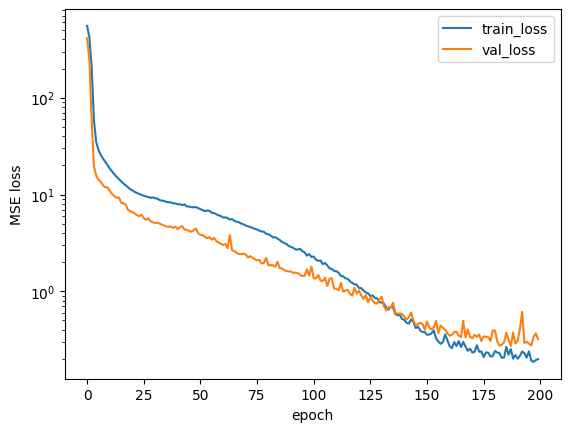

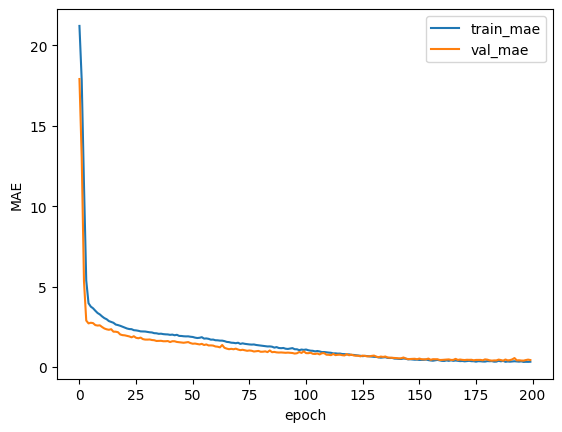

In [14]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')  # optional for clarity
plt.xlabel('epoch'); plt.ylabel('MSE loss'); plt.legend(); plt.show()

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('epoch'); plt.ylabel('MAE'); plt.legend(); plt.show()


Evaluate on test set

In [15]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test MAE: {test_mae:.3f}")


Test MAE: 0.437


Predict & compare

In [16]:
preds = model.predict(X_test_scaled).flatten()
for i in range(10):
    print(f"pred: {preds[i]:.2f}   actual: {y_test.iloc[i]:.2f}   error: {preds[i]-y_test.iloc[i]:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pred: 16.94   actual: 16.47   error: 0.47
pred: 13.33   actual: 13.17   error: 0.16
pred: 32.92   actual: 32.82   error: 0.10
pred: 42.00   actual: 41.32   error: 0.68
pred: 17.06   actual: 16.69   error: 0.37
pred: 23.28   actual: 23.80   error: -0.52
pred: 24.16   actual: 24.31   error: -0.15
pred: 28.63   actual: 28.67   error: -0.04
pred: 18.69   actual: 19.52   error: -0.83
pred: 28.78   actual: 28.07   error: 0.71


Save & load model

In [24]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])


In [25]:
model.save("energy_model.keras")


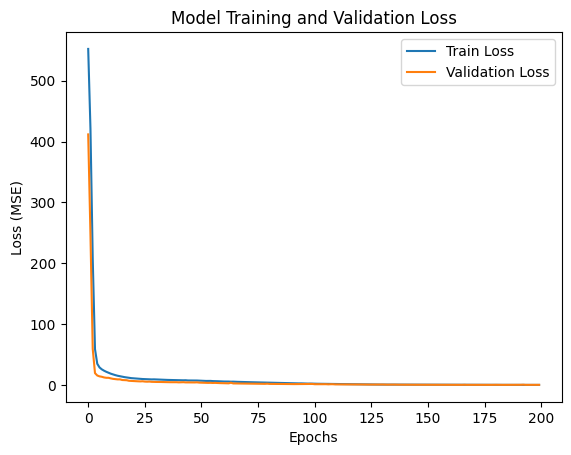

In [35]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Training and Validation Loss')
plt.legend()
plt.show()


In [36]:
from tensorflow.keras.models import load_model
loaded_model = load_model("energy_model.keras")

# (optional) recompile again just in case
loaded_model.compile(optimizer='adam',
                     loss='mean_squared_error',
                     metrics=['mean_absolute_error'])

# test it
loss, mae = loaded_model.evaluate(X_test, y_test)
print("Reloaded Model Test MAE:", mae)


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1199689.7500 - mean_absolute_error: 980.5881  
Reloaded Model Test MAE: 993.4468994140625


In [34]:
loss, mae = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Reloaded Model Test MAE:", mae)

# Example prediction
sample = X_test[:5]
pred = loaded_model.predict(sample)
print("Predicted Energy Efficiency:", pred)


Reloaded Model Test MAE: 993.4468994140625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Energy Efficiency: [[1308.9861 ]
 [1435.9567 ]
 [ 458.2692 ]
 [ 696.15533]
 [1372.8823 ]]
